# xAPIステートメントの分析

In [1]:
import json
import requests
import socket
import urllib.parse

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## xAPIステートメントをAPIサーバから取得
<span style="color:red"><b>Learning Lockerで作成したLRSのクライアント情報を設定すること。</b></span>

In [2]:
user = '<Key>'
passwd = '<Secret>'

Learning LockerのAggregation APIを用いてステートメントを取得する。
APIの詳細は[AGGREGATION HTTP INTERFACE](https://learninglocker.atlassian.net/wiki/spaces/DOCS/pages/106037259/Aggregation+API)を参照すること。

In [3]:
pipeline = urllib.parse.quote(json.dumps([
    {'$project': {
        'timestamp': 1,
        'statement': 1,
        '_id': 0
    }},
    {'$match': {
        #'statement.verb.id': 'http://www.adlnet.gov/expapi/verbs/initialized',
        #'statement.actor.account.name': 'admin',
        #'statement.object.definition.type': 'http://adlnet.gov/expapi/activities/session-ended',
         'timestamp': {
             "$gte": {
                 '$dte': '2020-04-01T00:00:00Z'
             },
             "$lte": {
                 '$dte': '2021-10-01T00:00:00Z'
             }
         }
    }},
    {'$limit': 30000},
]))
url = f'http://{socket.gethostbyname("learninglocker")}:8080/statements/aggregate?cache=false&pipeline={pipeline}'
r = requests.get(url, auth=(user, passwd))
response_data = json.loads(r.text)
stats = [d['statement'] for d in response_data]
print(f'#Statements: {len(stats)}')

#Statements: 4100


## ステートメントの可視化

In [4]:
# ネスト項目をフラットにしてpandasのDataFrameを作成
df = pd.io.json.json_normalize(stats)
# 配列要素であるContextを分解
def convert(row):
    parent = row['context.contextActivities.parent']
    if not pd.isnull(parent):
        return parent[0]['id']
    return parent
df['context.contextActivities.parent.id'] = df.apply(convert, axis=1)
df['context.contextActivities.parent.objectType'] = 'Activity'
df.drop(['context.contextActivities.parent'], axis=1, inplace=True)

pd.set_option('display.max_columns', 100)
df.head()

,id,timestamp,stored,version,actor.name,actor.account.name,actor.account.homePage,actor.objectType,verb.id,object.definition.type,object.id,object.objectType,authority.objectType,authority.name,authority.mbox,object.definition.name.en-US,object.definition.description.en-US,result.completion,result.extensions.http://sakaiproject.org/xapi/extensions/result/classification.definition.name.en-US,result.extensions.http://sakaiproject.org/xapi/extensions/result/classification.definition.type,result.extensions.http://sakaiproject.org/xapi/extensions/result/classification.id,result.extensions.http://sakaiproject.org/xapi/extensions/result/classification.objectType,result.score.min,result.score.max,result.score.raw,context.contextActivities.parent.id,context.contextActivities.parent.objectType
0,b0032276-c483-4e71-a713-a00a972086c1,2021-06-30T00:00:03+00:00,2021-12-10T05:28:06.774Z,1.0.0,Dummy Instructor,instructor-0,http://localhost:8888,Agent,http://www.adlnet.gov/expapi/verbs/exited,http://adlnet.gov/expapi/activities/session-ended,http://localhost:8888/portal/logout,Activity,Agent,New Client,mailto:hello@learninglocker.net,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Activity
1,3dcc2625-eaa9-4fa2-9fa4-ee8e5618565c,2021-04-15T08:11:07+00:00,2021-12-10T05:28:08.262Z,1.0.0,Dummy Instructor,instructor-0,http://localhost:8888,Agent,http://www.adlnet.gov/expapi/verbs/interacted,http://adlnet.gov/expapi/activities/created-topic,http://localhost:8888/portal/forums,Activity,Agent,New Client,mailto:hello@learninglocker.net,User created a new topic,User created a new topic with subject: example...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://localhost:8888/portal/site/3b1f66a5-221...,Activity
2,78927e13-f15e-4239-a7f7-2d8478e4a7ec,2021-06-25T23:16:12+00:00,2021-12-10T05:28:09.456Z,1.0.0,Dummy Instructor,instructor-0,http://localhost:8888,Agent,http://www.adlnet.gov/expapi/verbs/interacted,http://adlnet.gov/expapi/activities/created-topic,http://localhost:8888/portal/forums,Activity,Agent,New Client,mailto:hello@learninglocker.net,User created a new topic,User created a new topic with subject: example...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://localhost:8888/portal/site/3b1f66a5-221...,Activity
3,4be55fee-24dc-4909-abfc-fc3a9050d1bf,2021-04-07T13:58:16+00:00,2021-12-10T05:28:09.456Z,1.0.0,Dummy Instructor,instructor-0,http://localhost:8888,Agent,http://www.adlnet.gov/expapi/verbs/scored,http://adlnet.gov/expapi/activities/received-g...,http://localhost:8888/portal/assignment/s/46bf...,Activity,Agent,New Client,mailto:hello@learninglocker.net,User received a grade,User received a grade for their assginment: ex...,True,D,http://sakaiproject.org/xapi/activitytypes/gra...,http://sakaiproject.org/xapi/activities/D,activity,NaN,NaN,NaN,http://localhost:8888/portal/site/3b1f66a5-221...,Activity
4,a0f26ca3-0c8b-4e49-b159-b2121cae6b2c,2021-05-12T03:21:35+00:00,2021-12-10T05:28:09.456Z,1.0.0,Dummy Instructor,instructor-0,http://localhost:8888,Agent,http://www.adlnet.gov/expapi/verbs/scored,http://adlnet.gov/expapi/activities/question-s...,http://localhost:8888/portal/assessment,Activity,Agent,New Client,mailto:hello@learninglocker.net,Question score updated,Student score updated for: example-assessment-...,True,NaN,NaN,NaN,NaN,0.0,100.0,98.8,http://localhost:8888/portal/site/3b1f66a5-221...,Activity


### Verbの件数を集計

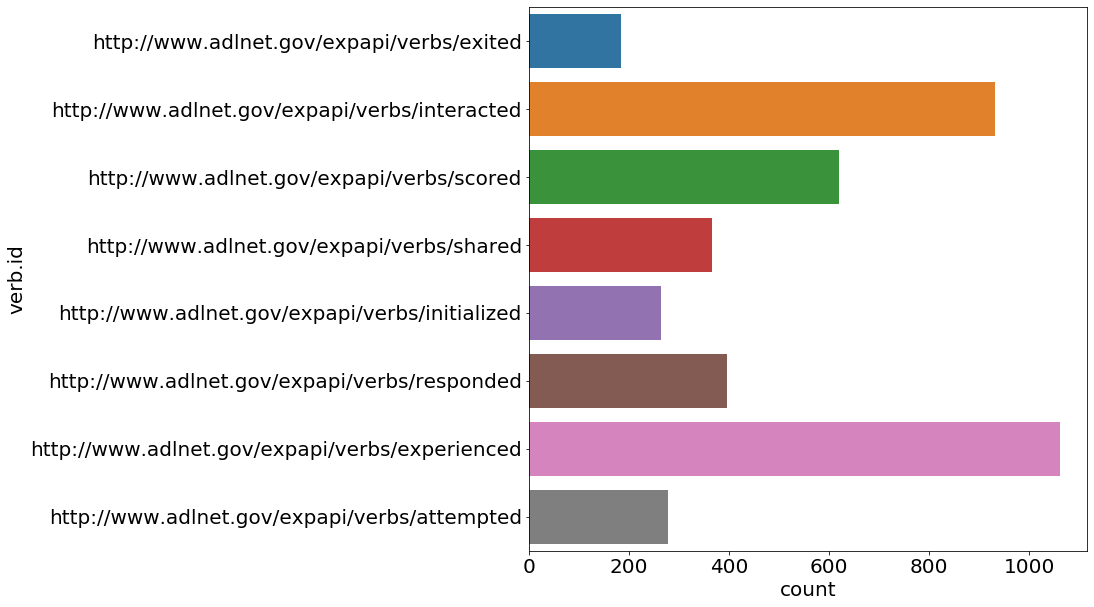

In [5]:
plt.figure(figsize=(10, 10))
plt.rcParams["font.size"] = 20
sns.countplot(y='verb.id', data=df)

## ステートメントの加工
以降では、Assignmentsの採点（ `asn.grade.submission` ）をより詳細にSupersetで可視化するためのステートメント加工処理を示す。

### 不要な項目を除外
分析対象外の項目を削除する。

In [6]:
df.drop(['version', 'authority.objectType', 'authority.name', 'authority.mbox'], axis=1, inplace=True)
df.head()

,id,timestamp,stored,actor.name,actor.account.name,actor.account.homePage,actor.objectType,verb.id,object.definition.type,object.id,object.objectType,object.definition.name.en-US,object.definition.description.en-US,result.completion,result.extensions.http://sakaiproject.org/xapi/extensions/result/classification.definition.name.en-US,result.extensions.http://sakaiproject.org/xapi/extensions/result/classification.definition.type,result.extensions.http://sakaiproject.org/xapi/extensions/result/classification.id,result.extensions.http://sakaiproject.org/xapi/extensions/result/classification.objectType,result.score.min,result.score.max,result.score.raw,context.contextActivities.parent.id,context.contextActivities.parent.objectType
0,b0032276-c483-4e71-a713-a00a972086c1,2021-06-30T00:00:03+00:00,2021-12-10T05:28:06.774Z,Dummy Instructor,instructor-0,http://localhost:8888,Agent,http://www.adlnet.gov/expapi/verbs/exited,http://adlnet.gov/expapi/activities/session-ended,http://localhost:8888/portal/logout,Activity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Activity
1,3dcc2625-eaa9-4fa2-9fa4-ee8e5618565c,2021-04-15T08:11:07+00:00,2021-12-10T05:28:08.262Z,Dummy Instructor,instructor-0,http://localhost:8888,Agent,http://www.adlnet.gov/expapi/verbs/interacted,http://adlnet.gov/expapi/activities/created-topic,http://localhost:8888/portal/forums,Activity,User created a new topic,User created a new topic with subject: example...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://localhost:8888/portal/site/3b1f66a5-221...,Activity
2,78927e13-f15e-4239-a7f7-2d8478e4a7ec,2021-06-25T23:16:12+00:00,2021-12-10T05:28:09.456Z,Dummy Instructor,instructor-0,http://localhost:8888,Agent,http://www.adlnet.gov/expapi/verbs/interacted,http://adlnet.gov/expapi/activities/created-topic,http://localhost:8888/portal/forums,Activity,User created a new topic,User created a new topic with subject: example...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://localhost:8888/portal/site/3b1f66a5-221...,Activity
3,4be55fee-24dc-4909-abfc-fc3a9050d1bf,2021-04-07T13:58:16+00:00,2021-12-10T05:28:09.456Z,Dummy Instructor,instructor-0,http://localhost:8888,Agent,http://www.adlnet.gov/expapi/verbs/scored,http://adlnet.gov/expapi/activities/received-g...,http://localhost:8888/portal/assignment/s/46bf...,Activity,User received a grade,User received a grade for their assginment: ex...,True,D,http://sakaiproject.org/xapi/activitytypes/gra...,http://sakaiproject.org/xapi/activities/D,activity,NaN,NaN,NaN,http://localhost:8888/portal/site/3b1f66a5-221...,Activity
4,a0f26ca3-0c8b-4e49-b159-b2121cae6b2c,2021-05-12T03:21:35+00:00,2021-12-10T05:28:09.456Z,Dummy Instructor,instructor-0,http://localhost:8888,Agent,http://www.adlnet.gov/expapi/verbs/scored,http://adlnet.gov/expapi/activities/question-s...,http://localhost:8888/portal/assessment,Activity,Question score updated,Student score updated for: example-assessment-...,True,NaN,NaN,NaN,NaN,0.0,100.0,98.8,http://localhost:8888/portal/site/3b1f66a5-221...,Activity


### 例1: result.extensionsをSupersetで取り扱うために項目名を短縮
Grade ScaleがPoints以外のAssignmentで設定される `result.extensions` について、カラム名の文字数制限により、そのままではSupersetで扱えないため名前を短縮する。

In [7]:
df.rename(
    columns=lambda x: x.replace(
        'result.extensions.http://sakaiproject.org/xapi/extensions/result/classification',
        'result.extensions.classification'
    ),
    inplace=True
)
df.head()

,id,timestamp,stored,actor.name,actor.account.name,actor.account.homePage,actor.objectType,verb.id,object.definition.type,object.id,object.objectType,object.definition.name.en-US,object.definition.description.en-US,result.completion,result.extensions.classification.definition.name.en-US,result.extensions.classification.definition.type,result.extensions.classification.id,result.extensions.classification.objectType,result.score.min,result.score.max,result.score.raw,context.contextActivities.parent.id,context.contextActivities.parent.objectType
0,b0032276-c483-4e71-a713-a00a972086c1,2021-06-30T00:00:03+00:00,2021-12-10T05:28:06.774Z,Dummy Instructor,instructor-0,http://localhost:8888,Agent,http://www.adlnet.gov/expapi/verbs/exited,http://adlnet.gov/expapi/activities/session-ended,http://localhost:8888/portal/logout,Activity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Activity
1,3dcc2625-eaa9-4fa2-9fa4-ee8e5618565c,2021-04-15T08:11:07+00:00,2021-12-10T05:28:08.262Z,Dummy Instructor,instructor-0,http://localhost:8888,Agent,http://www.adlnet.gov/expapi/verbs/interacted,http://adlnet.gov/expapi/activities/created-topic,http://localhost:8888/portal/forums,Activity,User created a new topic,User created a new topic with subject: example...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://localhost:8888/portal/site/3b1f66a5-221...,Activity
2,78927e13-f15e-4239-a7f7-2d8478e4a7ec,2021-06-25T23:16:12+00:00,2021-12-10T05:28:09.456Z,Dummy Instructor,instructor-0,http://localhost:8888,Agent,http://www.adlnet.gov/expapi/verbs/interacted,http://adlnet.gov/expapi/activities/created-topic,http://localhost:8888/portal/forums,Activity,User created a new topic,User created a new topic with subject: example...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://localhost:8888/portal/site/3b1f66a5-221...,Activity
3,4be55fee-24dc-4909-abfc-fc3a9050d1bf,2021-04-07T13:58:16+00:00,2021-12-10T05:28:09.456Z,Dummy Instructor,instructor-0,http://localhost:8888,Agent,http://www.adlnet.gov/expapi/verbs/scored,http://adlnet.gov/expapi/activities/received-g...,http://localhost:8888/portal/assignment/s/46bf...,Activity,User received a grade,User received a grade for their assginment: ex...,True,D,http://sakaiproject.org/xapi/activitytypes/gra...,http://sakaiproject.org/xapi/activities/D,activity,NaN,NaN,NaN,http://localhost:8888/portal/site/3b1f66a5-221...,Activity
4,a0f26ca3-0c8b-4e49-b159-b2121cae6b2c,2021-05-12T03:21:35+00:00,2021-12-10T05:28:09.456Z,Dummy Instructor,instructor-0,http://localhost:8888,Agent,http://www.adlnet.gov/expapi/verbs/scored,http://adlnet.gov/expapi/activities/question-s...,http://localhost:8888/portal/assessment,Activity,Question score updated,Student score updated for: example-assessment-...,True,NaN,NaN,NaN,NaN,0.0,100.0,98.8,http://localhost:8888/portal/site/3b1f66a5-221...,Activity


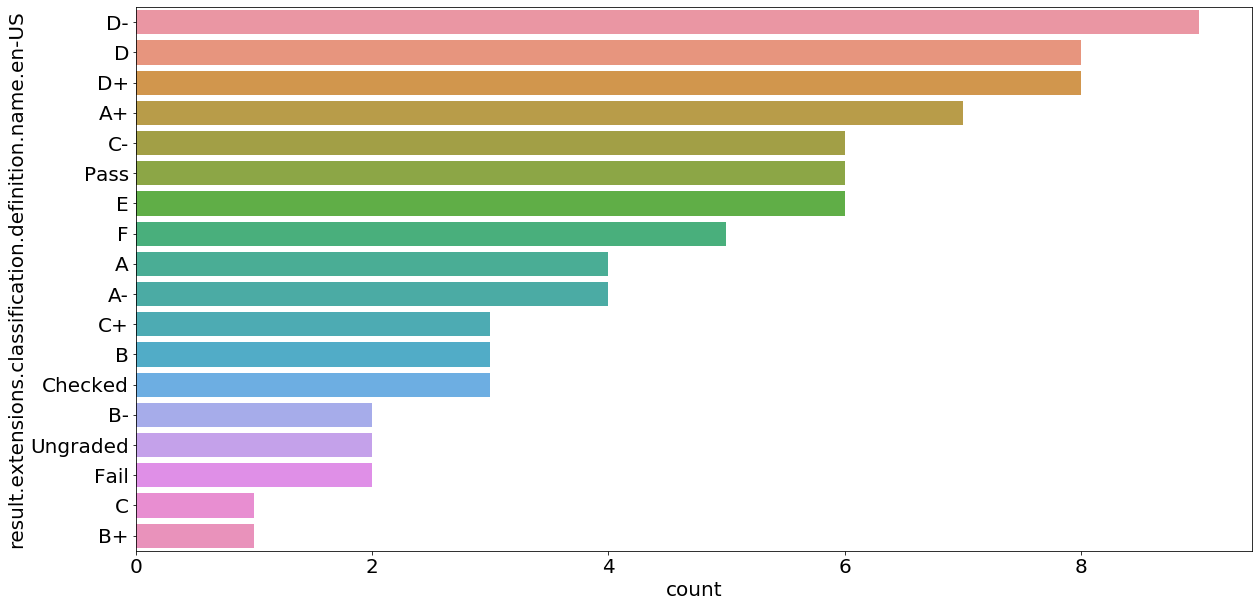

In [8]:
plt.figure(figsize=(20, 10))
sns.countplot(
    # Gradeの件数を集計
    y='result.extensions.classification.definition.name.en-US',
    data=df,
    # 件数でソート
    order=df['result.extensions.classification.definition.name.en-US'].value_counts().index
)

### 例2: Assignmentの名前を項目化
評価対象となったAssignmentの名称を取り扱えるように、 `object.definition.description.en-US` に含む名前を項目化する。

In [9]:
import numpy as np
import re
def extract_asn_name(row):
    if row['object.definition.type'] == 'http://adlnet.gov/expapi/activities/received-grade-assignment':
        return re.split('User received a grade for their assginment: |; Submission', row['object.definition.description.en-US'])[1]
    return np.nan

df['received_grade_assignment_name'] = df.apply(extract_asn_name, axis=1)
df[df['received_grade_assignment_name'].notnull()]['received_grade_assignment_name'].head()

3     example-asn-17
5      example-asn-7
14    example-asn-11
16    example-asn-18
19     example-asn-5
Name: received_grade_assignment_name, dtype: object

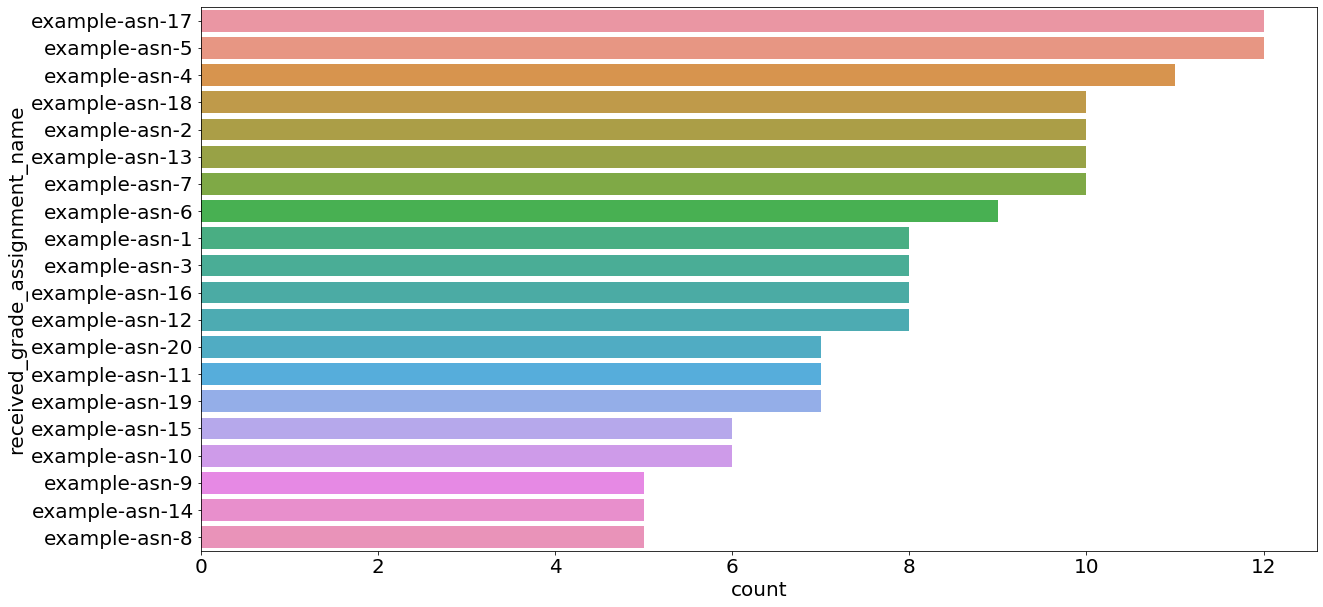

In [10]:
plt.figure(figsize=(20, 10))
sns.countplot(
    # 採点対象となったAssignment名
    y='received_grade_assignment_name',
    data=df,
    # 件数でソート
    order=df['received_grade_assignment_name'].value_counts().index
)

# Supersetに実行結果を保存

In [11]:
from sqlalchemy import create_engine
from sqlalchemy.types import TIMESTAMP, VARCHAR

In [12]:
# Supersetのjupyterデータベースに処理結果を保存
engine = create_engine('postgresql://postgres@superset-db:5432/jupyter')
# 任意のテーブル名を設定
tablename = 'jupyter_results'

df.to_sql(
    tablename,
    engine,
    index=False,
    # 既に同名テーブルが存在する場合は上書き
    if_exists='replace',
    # 必要に応じてdtypeでカラムの属性を指定する
    dtype={
        'id': VARCHAR(),
        'actor.name': VARCHAR(),
        'actor.account.name': VARCHAR(),
        'actor.account.homePage': VARCHAR(),
        'actor.objectType': VARCHAR(),
        'verb.id': VARCHAR(),
        'object.definition.type': VARCHAR(),
        'object.id': VARCHAR(),
        'object.objectType': VARCHAR(),
        'object.definition.name.en-US': VARCHAR(),
        'object.definition.description.en-US': VARCHAR(),
        'context.contextActivities.parent.id': VARCHAR(),
        'context.contextActivities.parent.objectType': VARCHAR(),
        'stored': TIMESTAMP(),
        'timestamp': TIMESTAMP(),
        # リネームした項目
        'result.extensions.classification.definition.name.en-US': VARCHAR(),
        'result.extensions.classification.definition.type': VARCHAR(),
        'result.extensions.classification.id': VARCHAR(),
        'result.extensions.classification.objectType': VARCHAR(),
        # 新規追加した項目
        'received_grade_assignment_name': VARCHAR(),
    }
)